# SETUP

In [20]:
using LinearAlgebra, Plots, JuMP, ECOS, LaTeXStrings, Random, Statistics

pgfplotsx()
default(lab="",markersize=3,lw=1.5,markerstrokewidth=0.1,xtickfontsize=15,ytickfontsize=15,legendfontsize=7,
    xlabelfontsize=15,labelfontsize=15,minorgrid=true);

In [4]:
function set_reference!(Γ::Dict{Symbol,Any})    
    ### target state solely as reference for generating the reference for reference
    
    # x̂f::Array{Float64,1} = [0.5*(Γ[:rc]+Γ[:rX]),-0.5*Γ[:rX],0.0,0.2]
    x̂f::Array{Float64,1} = [0.1*Γ[:rc]+0.9*Γ[:rX],-0.9*Γ[:rX],0.0,0.0]
    x̂::Array{Array{Float64,1}} = cat([Γ[:x0]],[x̂f for t=1:Γ[:T]],dims=1)
    Γ[:x̂] = x̂
    
    return Γ
end

function problem_data(T::Int64,kmax::Int64=1000,is_x0_supplied::Bool=false,is_x̂_supplied::Bool=false,
        x̂_supplied::Array{Array{Float64,1}}=[[0.0,0.0],[0.0,0.0]],x0_supplied::Array{Float64,1}=[0.0,0.0])
    
    # dictionary for holding problem data
    Γ = Dict{Symbol,Any}() # creating an empty dictionary with the type of the key specified  
    
    Γ[:T] = T
    Γ[:kmax] = kmax
    
    nx::Int64 = 4;       Γ[:nx] = nx
    nu::Int64 = 2;       Γ[:nu] = nu

    rc::Float64 = 2.0;              Γ[:rc] = rc
    rX::Float64 = 3.0;              Γ[:rX] = rX
    rV::Float64 = 0.25;             Γ[:rV] = rV 
    rU::Float64 = 0.1;              Γ[:rU] = rU
    zc::Array{Float64,1} = [0,-rX]; Γ[:zc] = zc

    Δ::Float64 = 0.5; # sampling time
    Ac::Array{Float64,2} = [0 0 1 0;0 0 0 1;0 0 0 0;0 0 0 0]
    Bc::Array{Float64,2} = [0 0;0 0;1 0;0 1]                      
    Ad::Array{Float64,2} = exp(Ac*Δ)
    Bd::Array{Float64,2} = (Δ*I + Ac*0.5*Δ^2)*Bc
    D::Array{Float64,2} = [1 0 0 0;0 1 0 0]
    
    if is_x0_supplied
        if length(x0_supplied)==2
           error("Supply a valid x0.")
        end
        Γ[:x0] = x0_supplied
    else
        Γ[:x0] = [-0.5*(Γ[:rc]+Γ[:rX]),-0.8*Γ[:rX],0.0,0.0]
        # Γ[:x0] = [-2.8,-2.0,0.0,0.0]
    end
    
    if is_x̂_supplied
        if length(x̂_supplied)==2
            error("Supply a valid reference.")
        end
        Γ[:x̂] = x̂_supplied
    else
        Γ = set_reference!(Γ)
    end
    
    A = Array{Array{Float64,2}}(undef,T+1) # t = 0:T
    B = Array{Array{Float64,2}}(undef,T)   # t = 0:T-1
    Q = Array{Array{Float64,2}}(undef,T)   # t = 1:T
    R = Array{Array{Float64,2}}(undef,T)   # t = 0:T-1
    q = Array{Array{Float64,1}}(undef,T)   # t = 1:T

    C = Array{Array{Float64,1}}(undef,T) # t = 1:T
    d = Array{Float64,1}(undef,T)
    for t in 1:T
        
        # C and d independent of T
        C[t] = -transpose(D)*[cos(pi*(1-0.02*t)),sin(pi*(1-0.02*t))]
        d[t] = -[cos(pi*(1-0.02*t)),sin(pi*(1-0.02*t))]⋅zc - rc
        
        A[t] = Ad
        B[t] = Bd
        
        Q[t] = [1.0 0.0 0.0 0.0;0.0 0.5 0.0 0.0;0.0 0.0 1.0 0.0;0.0 0.0 0.0 0.5]
        R[t] = [1.0 0.0;0.0 0.5]
        
        q[t] = -Q[t]*Γ[:x̂][t+1]
    end
    A[T+1] = zeros(Float64,nx,nx)
    
    Γ[:A] = A
    Γ[:B] = B
    Γ[:Q] = Q
    Γ[:R] = R
    Γ[:q] = q
    Γ[:C] = C
    Γ[:d] = d
    
    Γ[:ρ_ADMM] = 2.0
    Γ[:ϵ_nest] = 0.01 # for relative accuracy
    kmax_nest::Int64 = 1000; Γ[:kmax_nest] = kmax_nest
    Γ[:ϵ_outerloop] = 0.01 # for relative accuracy
    
    # upper triangular Cholesky factorization for Q and R (needed when they are non-diagonal)
    Γ[:cholQ] = [Matrix(cholesky(Q[t]).U) for t = 1:T]
    Γ[:cholR] = [Matrix(cholesky(R[t]).U) for t = 1:T]
    
    nunx = nu+nx
    
    # constuct G and H
    G1 = zeros(nx,nunx*T)
    G2 = zeros((T-1)*nx,nunx*T)

    G1[:,1:nunx] = hcat(-B[1],Diagonal(ones(nx)))
    
    H = zeros(Float64,nunx*T,nunx*T)
    H[1:nunx,1:nunx] = vcat(hcat(R[1],zeros(Float64,nu,nx)),
        hcat(zeros(Float64,nx,nu),Q[1]))
       
    for j = 1:T-1
        G2[(j-1)*nx+1:j*nx,nu+(j-1)*nunx+1:nu+j*nunx+nx] = hcat(-A[j+1],-B[j+1],Diagonal(ones(nx)))
        H[j*nunx+1:(j+1)*nunx,j*nunx+1:(j+1)*nunx] = vcat(hcat(R[j+1],zeros(Float64,nu,nx)),
            hcat(zeros(nx,nu),Q[j+1]))        
    end

    G = vcat(G1,G2)
    
    M = inv( Matrix( vcat( hcat( H .+ Γ[:ρ_ADMM].*Diagonal(ones(nunx*T)) , transpose(G) ), hcat( G , zeros(nx*T,nx*T) ) ) ) )
    M11 = M[1:nunx*T,1:nunx*T]
    M12 = M[1:nunx*T,nunx*T+1:end] 
    
    # construct g and h
    g = zeros(Float64,nx*T)
    g[1:nx] = A[1]*Γ[:x0]
    
    h = zeros(Float64,nunx*T)
    for t=1:T
        h[(t-1)*nunx+1:t*nunx] = cat(zeros(nu),q[t],dims=1)
    end
    
    # computation of σ, μ and λ
    sGTG = svd(transpose(G)*G)
    σ = sGTG.S[1]
    
    sH = svd(H)
    λ = sH.S[1]
    μ = sH.S[end]
    
    # extracting x and u from stacked z
    u_idx = Array{Array{Int64,1}}(undef,T)
    x_idx = Array{Array{Int64,1}}(undef,T)
    for t = 1:T
        u_idx[t] = (1:nu) .+ (t-1)*nunx
        x_idx[t] = ((nu+1):nunx) .+ (t-1)*nunx
    end
    Γ[:x_idx] = x_idx
    Γ[:u_idx] = u_idx
    
    Γ[:σ] = σ
    Γ[:μ] = μ
    Γ[:λ] = λ
    
    Γ[:M11] = M11
    Γ[:M12] = M12
    Γ[:H] = H
    Γ[:h] = h
    Γ[:G] = G
    Γ[:g] = g
    
    return Γ
end

problem_data (generic function with 6 methods)

## Plotting

In [27]:
function plotfeasibleset_coarse(Γ)
    
    rc = Γ[:rc]
    zc = Γ[:zc]
    
    xc = zc[1] .+ range(-rc,rc,length=100);
    yc = zc[2] .+ (rc^2 .- xc.^2).^0.5;
    p1 = plot(xc,yc,color=:black)
    
    return p1   
end

function plotfeasibleset(Γ)
    
    rc = Γ[:rc]
    zc = Γ[:zc]
    x̂i = Γ[:x̂][1]
    x̂f = Γ[:x̂][end]
    
    rX = norm(zc,Inf)
    
    p1 = plot([x̂i[1]],[x̂i[2]],marker=:square,label=L"p_0",color=:blue,markersize=5)
    plot!([x̂f[1]],[x̂f[2]],marker=:dot,label=L"\hat{p}_T",color=:green) 
    plot!(xlim=[-1.1*rX,1.1*rX])
    plot!(ylim=[-1.1*rX,1.1*rX])
    plot!(size=(800,400))
    
    if ~isnan(Γ[:x0_box_size])
        xb = Γ[:x0_box_size]
        x0_pos = Γ[:x0][1:2]
        xss = x0_pos[1] .+ [2*xb*(t/99) - xb for t=0:99]
        yss = x0_pos[2] .+ [2*xb*(t/99) - xb for t=0:99]
        M = length(xss)
        plot!(xss, (x0_pos[2]+xb).*ones(M), line=:solid, color=:magenta)
        plot!((x0_pos[1]+xb).*ones(M), yss, line=:solid, color=:magenta)
        plot!((x0_pos[1]-xb).*ones(M), yss, line=:solid, color=:magenta)
        plot!(xss, (x0_pos[2]-xb).*ones(M), line=:solid, color=:magenta)
    end
    
    xc = zc[1] .+ range(-rc,rc,length=100);
    yc = zc[2] .+ (rc^2 .- xc.^2).^0.5;
    plot!(xc,yc,color=:black)
    
    return p1   
end

function plot_func(x::Array{Array{Float64,1}},dynerr::Array{Float64,1},dist2opt::Array{Float64,1}
        ,terminate_criteria::Array{Float64,1},Γ::Dict{Symbol,Any})
    
    T = Γ[:T]
    rc = Γ[:rc]
    zc = Γ[:zc]
    x̂i = Γ[:x̂][1]
    x̂f = Γ[:x̂][end]
    
    p1 = plotfeasibleset(Γ)

    plot!(p1,[x[t][1] for t=1:T+1],[x[t][2] for t=1:T+1],color=:red,line=:solid,lw=1,label="Position")
    plot!(aspect_ratio=1,legend=:topleft)

    maxVel = max(norm([x[t][3] for t=1:T+1],Inf),norm([x[t][4] for t=1:T+1],Inf))
    
    p2 = plot([x[1][3]],[x[1][4]],marker=:square,label=L"\hat{y}_i",color=:blue)
    plot!([x[T+1][3]],[x[T+1][4]],marker=:dot,label=L"\hat{y}_f",color=:green)    
    plot!([x[t][3] for t=1:T+1],[x[t][4] for t=1:T+1],color=:red,line=:solid,lw=1,label="Velocity")
    plot!(xlim=[-1.1*maxVel,1.1*maxVel],ylim=[-1.1*maxVel,1.1*maxVel])
    plot!(size=(1000,1000))
    plot!(aspect_ratio=1,legend=:topleft)
    
    p3 = plot(dynerr.^2,color=:red,line=:solid,lw=1,label=L"\Vert Gz-g \Vert_2^2",yaxis=:log)
    plot!(dist2opt.^2,color=:blue,line=:solid,lw=1,label=L"\Vert z - z^\star \Vert_{\infty}^2",yaxis=:log)
    plot!(terminate_criteria,color=:green,line=:solid,lw=1,label=L"\Vert z - z^\star \Vert_2 / \Vert z^\star \Vert_2")
    plot!(Γ[:ϵ_outerloop].*ones(length(terminate_criteria)),color=:black,lw=1,line=:auto,label="")
    plot!(size=(1000,1000),xlabel=L"k")
    plot!(legend=:topright,title="Error curves")
    # plot!(ylim=[1e-8,10])

    λ = @layout [a b; c]
    return plot(p1,p2,p3,layout=λ)
end

function err_plot_func_coarse(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},xΨ)   
    
    T = Γ[:T]
    rV = Γ[:rV]
    rX = Γ[:rX]
    x̌ = Θ[:jump][:x]
    x̂ = Γ[:x̂]
    ϵ_nest = Γ[:ϵ_nest]
    ϵ = Γ[:ϵ_outerloop]
    
    print("Horizon length (T) = $T\n")
    print("Nesterov termination criteria is $(ϵ_nest*100) % relative change")
    print("\nOuter-loop termination criteria is norm(Gz-g,2) ≤ $ϵ")
    
    p1 = plotfeasibleset_coarse(Γ)
    
    plot!([xΨ[t][1] for t=1:60],[xΨ[t][2] for t=1:60],color=:magenta,line=:auto,lw=1.5,label="Reference")
    plot!([x̂[1][1]],[x̂[1][2]],marker=:square,label=L"p_0",color=:blue,markersize=5)
    plot!([xΨ[end][1]],[xΨ[end][2]],markershape=:circle,color=:magenta,label="")
    plot!([x̌[t][1] for t=1:T+1],[x̌[t][2] for t=1:T+1],color=:red,line=:solid,lw=1.5,label="")
    plot!(xlim=[-1.1*rX,1.1*rX])
    plot!(ylim=[-1.1*rX,1.1*rX])
    plot!(size=(1000,1000))
    plot!(aspect_ratio=1,legend=:topleft,legendfontsize=12,legendtitle="Position")

    maxVel = max(norm([x̌[t][3] for t=1:T+1],Inf),norm([x̌[t][4] for t=1:T+1],Inf))
    
    p2 = plot([xΨ[t][3] for t=1:60],[xΨ[t][4] for t=1:60],color=:magenta,line=:dash,lw=1.5,label="Reference")
    plot!([x̂[1][3]],[x̂[1][4]],marker=:square,label=L"q_0",color=:blue,markersize=5)
    plot!([xΨ[end][3]],[xΨ[end][4]],markershape=:circle,color=:magenta,label="")
    plot!([x̌[t][3] for t=1:T+1],[x̌[t][4] for t=1:T+1],color=:red,line=:solid,lw=1.5,label="")
    plot!(xlim=[-1.1*rV,1.1*rV],ylim=[-1.1*rV,1.1*rV])
    plot!(size=(1000,1000))
    plot!(aspect_ratio=1,legend=:topleft,legendfontsize=12,legendtitle="Velocity")
    
    k1 = Θ[:alg1][:k]
    k1a = Θ[:alg1a][:k]
    k2 = Θ[:alg2][:k]
    k3 = Θ[:alg3][:k]
    k4 = Θ[:alg4][:k]
    k5 = Θ[:alg5][:k]
    maxk = maximum([k1,k1a,k2,k3,k4,k5])
    
    p4 = plot(Θ[:alg1][:dye][1:k1],color=:red,line=:solid,lw=1,label="Our method (var. step)",yaxis=:log)
    plot!(Θ[:alg1a][:dye][1:k1a],color=:magenta,line=:auto,lw=1,label="Our method (const. step)",yaxis=:log)
    plot!(Θ[:alg2][:dye][1:k2],color=:blue,line=:solid,lw=1,label="Dual fast grad.",yaxis=:log)
    plot!(Θ[:alg3][:dye][1:k3],color=:cyan,line=:solid,lw=1,label="Chambolle & Pock",yaxis=:log)
    plot!(Θ[:alg4][:dye][1:k4],color=:orange,line=:solid,lw=1,label="Matrix split.",yaxis=:log)
    plot!(Θ[:alg5][:dye][1:k5],color=:green,line=:solid,lw=1,label="ADMM",yaxis=:log)
    plot!(size=(1000,1000),xlabel=L"k")
    plot!(title=L"\|Gz-g\|_2^2",legend=:topright)
    
    p3 = plot(Θ[:alg1][:d2o][1:k1],color=:red,line=:solid,lw=1,label="")
    plot!(Θ[:alg1a][:d2o][1:k1a],color=:magenta,line=:auto,lw=1,label="")
    plot!(Θ[:alg2][:d2o][1:k2],color=:blue,line=:solid,lw=1,label="")
    plot!(Θ[:alg3][:d2o][1:k3],color=:cyan,line=:solid,lw=1,label="")
    plot!(Θ[:alg4][:d2o][1:k4],color=:orange,line=:solid,lw=1,label="")
    plot!(Θ[:alg5][:d2o][1:k5],color=:green,line=:solid,lw=1,label="")
    plot!(size=(1000,1000),xlabel=L"k",title=L"\|z-z^\star\|_\infty^2",yaxis=(:log10))
    plot!(xlim=[1,maxk])
    
    λ = @layout [a b; c d]
    p5 = plot(p1,p2,p3,p4,layout=λ)
    
end



err_plot_func_coarse (generic function with 1 method)

## Projection functions

In [6]:
function project_u(u::Array{Float64,1},rU::Float64)
    return rU*u./max(norm(u,2),rU)
end

function project_x(x::Array{Float64,1},C::Array{Float64,1},d::Float64,rV::Float64)
    x[3:4] = x[3:4].*(rV/max(rV,norm(x[3:4],2)))
    C⋅x-d≤0 ? x : x - (C⋅x-d)*C    
end

function project_z(z::Array{Float64,1},x_idx::Array{Array{Int64,1}},u_idx::Array{Array{Int64,1}},
        T::Int64,C::Array{Array{Float64,1}},d::Array{Float64,1},rV::Float64,rU::Float64)
    for t = 1:T
        z[x_idx[t]] = project_x(z[x_idx[t]],C[t],d[t],rV)
        z[u_idx[t]] = project_u(z[u_idx[t]],rU)
    end    
    return z
end

project_z (generic function with 1 method)

## `nesterov`

In [7]:
function nesterov(z::Array{Float64,1},P::Array{Float64,2},p::Array{Float64,1},κ::Float64,ρinv::Float64,
        kmax::Int64,ϵ::Float64,x_idx::Array{Array{Int64,1}},u_idx::Array{Array{Int64,1}},
        T::Int64,C::Array{Array{Float64,1}},d::Array{Float64,1},rV::Float64,rU::Float64)
    y = copy(z)
    x = ones(Float64,size(z)) # solely for entering loop if z is init to zeros
    cntr::Int64 = 0
    while norm(z-x)/norm(x) > ϵ && cntr<kmax
        x[:] = z[:]
        z[:] = project_z(y[:]-ρinv.*(P*y[:]+p),x_idx,u_idx,T,C,d,rV,rU)
        y[:] = z[:] + κ.*(z[:]-x[:])
        cntr+=1
    end
    return z,cntr
end

nesterov (generic function with 1 method)

# Solution

## JuMP

In [8]:
function execute_jump!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},obstacle_include::Bool=true,print_flag::Bool=false)
    
    Θ[:jump] = Dict{Symbol,Any}()
    
    nx = Γ[:nx]
    nu = Γ[:nu]
    T = Γ[:T]
    rc = Γ[:rc]
    zc = Γ[:zc]
    rV = Γ[:rV]
    rU = Γ[:rU]
    x0 = Γ[:x0]
    x̂ = Γ[:x̂]
    A = Γ[:A]
    B = Γ[:B]
    Q = Γ[:Q]
    R = Γ[:R]
    C = Γ[:C]
    d = Γ[:d] 
    cholQ = Γ[:cholQ]
    cholR = Γ[:cholR]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    
    ## Solve using ECOS via JuMP

    dbl_intg = Model(optimizer_with_attributes(ECOS.Optimizer,"printlevel"=>0))
    set_silent(dbl_intg)
    @variable(dbl_intg,x[1:nx,1:T+1])
    @variable(dbl_intg,u[1:nu,1:T])
    @variable(dbl_intg,β1[1:T] ≥ 0)
    @variable(dbl_intg,β2[1:T] ≥ 0)

    # obstacle avoidance
    if obstacle_include
        @constraint(dbl_intg,[t=1:T],C[t]⋅x[:,t+1]-d[t] .≤ 0)
    end
    
    @constraint(dbl_intg,dyncon[t=1:T],[I -A[t] -B[t]]*cat(x[:,t+1],x[:,t],u[:,t],dims=1) .== 0)
    @constraint(dbl_intg,[t=1:T],[rU,u[:,t]...] in SecondOrderCone())
    @constraint(dbl_intg,[t=1:T],[rV,x[3:4,t+1]...] in SecondOrderCone())
    @constraint(dbl_intg,x[:,1] .== x0)

    @constraint(dbl_intg,[t=1:T],[β1[t],(cholR[t]*u[:,t])...] in SecondOrderCone())
    @constraint(dbl_intg,[t=1:T],[β2[t],(cholQ[t]*(x[:,t+1]-x̂[t+1]))...] in SecondOrderCone())
    @objective(dbl_intg,Min,0.5*sum(β1.^2)+0.5*sum(β2.^2))
    
    if print_flag
        print("\nExecuting JuMP (ECOS) ...\n")
    end
    # @time begin
    optimize!(dbl_intg)    
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    x = [value.(x)[:,t] for t=1:T+1]
    u = [value.(u)[:,t] for t=1:T]
    
    z = zeros(Float64,(nu+nx)*T)
    # store dual variable corresponding to dynamics constraint
    w = zeros(Float64,nx*T)
    for t = 1:T
        z[x_idx[t]] = x[t+1]
        z[u_idx[t]] = u[t]
        w[(t-1)*nx+1:t*nx] = [dual(dyncon[t][k]) for k=1:nx]
    end
    
    Θ[:jump][:x] = x
    Θ[:jump][:z] = z
    Θ[:jump][:w] = -w
    
    return Θ   
end

execute_jump! (generic function with 3 methods)

```
The succeeding JuMP function is required for storing the dual variables relevant to ADMM
```

In [9]:
# function execute_jump_ADMM_mod!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},obstacle_include::Bool=true,print_flag::Bool=false)
    
#     Θ[:jump] = Dict{Symbol,Any}()
    
#     nx = Γ[:nx]
#     nu = Γ[:nu]
#     T = Γ[:T]
#     rc = Γ[:rc]
#     zc = Γ[:zc]
#     rV = Γ[:rV]
#     rU = Γ[:rU]
#     x0 = Γ[:x0]
#     x̂ = Γ[:x̂]
#     A = Γ[:A]
#     B = Γ[:B]
#     Q = Γ[:Q]
#     R = Γ[:R]
#     C = Γ[:C]
#     d = Γ[:d] 
#     cholQ = Γ[:cholQ]
#     cholR = Γ[:cholR]
#     x_idx = Γ[:x_idx]
#     u_idx = Γ[:u_idx]
    
#     ## Solve using ECOS via JuMP

#     dbl_intg = Model(optimizer_with_attributes(ECOS.Optimizer,"printlevel"=>0))
#     set_silent(dbl_intg)
#     @variable(dbl_intg,x[1:nx,1:T+1])
#     @variable(dbl_intg,yy[1:nx,1:T+1])
#     @variable(dbl_intg,u[1:nu,1:T])
#     @variable(dbl_intg,vv[1:nu,1:T])
#     @variable(dbl_intg,β1[1:T] ≥ 0)
#     @variable(dbl_intg,β2[1:T] ≥ 0)

#     # obstacle avoidance
#     if obstacle_include
#         @constraint(dbl_intg,[t=1:T],C[t]⋅yy[:,t+1]-d[t] .≤ 0)
#     end
    
#     @constraint(dbl_intg,dyncon[t=1:T],[I -A[t] -B[t]]*cat(x[:,t+1],x[:,t],u[:,t],dims=1) .== 0)
#     @constraint(dbl_intg,[t=1:T],[rU,vv[:,t]...] in SecondOrderCone())
#     @constraint(dbl_intg,[t=1:T],[rV,yy[3:4,t+1]...] in SecondOrderCone())
#     @constraint(dbl_intg,x[:,1] .== x0)
    
#     @constraint(dbl_intg,yy[:,1] .== x0)
    
#     @constraint(dbl_intg,dual_x_ADMM[t=1:T],x[:,t+1] .== yy[:,t+1])
#     @constraint(dbl_intg,dual_u_ADMM[t=1:T],u[:,t] .== vv[:,t])

#     @constraint(dbl_intg,[t=1:T],[β1[t],(cholR[t]*u[:,t])...] in SecondOrderCone())
#     @constraint(dbl_intg,[t=1:T],[β2[t],(cholQ[t]*(x[:,t+1]-x̂[t+1]))...] in SecondOrderCone())
#     @objective(dbl_intg,Min,0.5*sum(β1.^2)+0.5*sum(β2.^2))
    
#     if print_flag
#         print("\nExecuting JuMP (ECOS) ...\n")
#     end
#     # @time begin
#     optimize!(dbl_intg)    
#     # end
#     if print_flag
#         print("\nDone.\n")
#     end
    
#     x = [value.(x)[:,t] for t=1:T+1]
#     u = [value.(u)[:,t] for t=1:T]
    
#     z = zeros(Float64,(nu+nx)*T)
    
#     # store dual variables for ADMM specific constraints
#     w_ADMM = zeros(Float64,(nx+nu)*T)
#     # store dual variable corresponding to dynamics constraint
#     w = zeros(Float64,nx*T)
#     for t = 1:T
#         z[x_idx[t]] = x[t+1]
#         z[u_idx[t]] = u[t]
#         w[(t-1)*nx+1:t*nx] = [dual(dyncon[t][k]) for k=1:nx]
#         w_ADMM[(t-1)*(nx+nu)+1:t*(nx+nu)] = cat([dual(dual_u_ADMM[t][k]) for k=1:nu],[dual(dual_x_ADMM[t][k]) for k=1:nx],dims=1)
#     end
    
#     Θ[:jump][:x] = x
#     Θ[:jump][:z] = z
#     Θ[:jump][:w] = -w
#     Θ[:jump][:w_ADMM] = -w_ADMM
    
#     return Θ   
# end

## Common initialization

In [10]:
# provides rand and obstacle-free JuMP solution as initialization
function common_initialization!(Θ::Dict{Symbol,Any},Ξ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},init_flg::Int64)
    nx = Γ[:nx]
    nu = Γ[:nu]
    T = Γ[:T]
    
    # dictionary to hold initialization
    Θ[:init] = Dict{Symbol,Any}()
    
    if init_flg == 2
    
        # use rand as initilization
        Θ[:init][:z] = rand(T*(nu+nx))
        Θ[:init][:w] = rand(T*nx)
        Θ[:init][:v_admm] = rand(T*(nu+nx))

    else
        if init_flg == 1
        
            # use obstacle-free JuMP solution as initialization
            Θ[:init][:z] = deepcopy(Ξ[:jump][:z])
            Θ[:init][:w] = deepcopy(Ξ[:jump][:w])
            Θ[:init][:v_admm] = deepcopy(Ξ[:jump][:w_ADMM])
        
        else
            
            error("Invalid initialization flag.")
        
        end
    end
    
    return Θ
end

# provides rand and randn initialization
function common_initialization_v2!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},init_flg::Int64)
    nx = Γ[:nx]
    nu = Γ[:nu]
    T = Γ[:T]
    
    # dictionary to hold initialization
    Θ[:init] = Dict{Symbol,Any}()
    
    if init_flg == 2
    
        # use rand as initilization
        Θ[:init][:z] = rand(T*(nu+nx))
        Θ[:init][:w] = rand(T*nx)
        Θ[:init][:v_admm] = rand(T*(nu+nx))

    elseif init_flg == 1
        
        # use randn as initilization
        Θ[:init][:z] = randn(T*(nu+nx))
        Θ[:init][:w] = randn(T*nx)
        Θ[:init][:v_admm] = randn(T*(nu+nx))
        
    else    
        error("Invalid initialization flag.")
    end
    
    return Θ
end

common_initialization_v2! (generic function with 1 method)

## Alg. 1: Proportional-integral Projected Gradient (var. step)

In [11]:
function execute_alg1!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg1] = Dict{Symbol,Any}()
    
    # initialization
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    w::Array{Float64,1} = deepcopy(Θ[:init][:w])
    
    λ = Γ[:λ]
    μ = Γ[:μ]
    σ = Γ[:σ]
    kmax::Int64 = Γ[:kmax]
    H = Γ[:H]
    G = Γ[:G]; GT = transpose(G)
    g = Γ[:g]
    h = Γ[:h]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    T = Γ[:T]
    C = Γ[:C]
    d = Γ[:d]
    rU = Γ[:rU]
    rV = Γ[:rV]
    ž = Θ[:jump][:z]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]
    
    μb2σ = 0.5*μ/σ
    
    dynerr = Array{Float64,1}(undef,kmax)
    dist2opt = Array{Float64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)
    
    α::Float64 = 0.0
    ρ::Float64 = 0.0
        
    k::Int64 = 1
    # terminate_criteria[1] = norm(z-ž)*inv_nrm_ž
    terminate_criteria[1] = norm(G*z[:]-g,Inf)
    
    if print_flag
        print("\nExecuting Primal-Dual Projected Gradient Method (var. step) ...\n")
    end
    # @time begin
    while k ≤ kmax && terminate_criteria[k] > ϵ_out
        
        dynerr[k] = norm(G*z[:]-g)
        dist2opt[k] = norm(z[:]-ž)
        
        # step-size update
        α = 2/((k+1)*μ+2*λ)
        ρ = (k+1)*μb2σ
        
        z = project_z(z-α.*(H*z+h+GT*w+ρ.*GT*(G*z-g)),x_idx,u_idx,T,C,d,rV,rU)
        w = w + ρ.*(G*z-g)
        
        terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
        k+=1
    end 
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    Θ[:alg1][:z] = z
    Θ[:alg1][:w] = w
    Θ[:alg1][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg1][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg1][:dye] = dynerr
    Θ[:alg1][:d2o] = dist2opt
    Θ[:alg1][:k] = k-1
    Θ[:alg1][:term_crit] = terminate_criteria
    return Θ
end

execute_alg1! (generic function with 2 methods)

## Alg. 1a: Proportional-integral Projected Gradient (const. step)

In [12]:
function execute_alg1a!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg1a] = Dict{Symbol,Any}()
    
    # initialization
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    w::Array{Float64,1} = deepcopy(Θ[:init][:w])
    
    λ = Γ[:λ]
    μ = Γ[:μ]
    σ = Γ[:σ]
    kmax::Int64 = Γ[:kmax]
    H = Γ[:H]
    G = Γ[:G]; GT = transpose(G)
    g = Γ[:g]
    h = Γ[:h]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    T = Γ[:T]
    C = Γ[:C]
    d = Γ[:d]
    rU = Γ[:rU]
    rV = Γ[:rV]
    ž = Θ[:jump][:z]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]
        
    dynerr = Array{Float64,1}(undef,kmax)
    dist2opt = Array{Float64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)

    # constant step-size
    α::Float64 = ( -λ + sqrt(λ^2 + 4*σ) )/(2*σ)
    ρ::Float64 = copy(α)
    
    k::Int64 = 1
    terminate_criteria[1] = norm(G*z[:]-g,Inf)
    
    if print_flag
        print("\nExecuting Primal-Dual Projected Gradient Method (const. step) ...\n")
    end
    # @time begin
    while k ≤ kmax && terminate_criteria[k] > ϵ_out
        
        dynerr[k] = norm(G*z[:]-g)
        dist2opt[k] = norm(z[:]-ž)
        
        z[:] = project_z(z[:]-α.*(H*z[:]+h+GT*w[:]+ρ.*GT*(G*z[:]-g)),x_idx,u_idx,T,C,d,rV,rU)
        w[:] = w[:] + ρ.*(G*z[:]-g)
        
        terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
        k+=1
    end 
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    Θ[:alg1a][:z] = z
    Θ[:alg1a][:w] = w
    Θ[:alg1a][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg1a][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg1a][:dye] = dynerr
    Θ[:alg1a][:d2o] = dist2opt
    Θ[:alg1a][:k] = k-1
    Θ[:alg1a][:term_crit] = terminate_criteria
    return Θ
end

execute_alg1a! (generic function with 2 methods)

## Alg. 2: Dual Fast Gradient

In [13]:
function execute_alg2!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg2] = Dict{Symbol,Any}()
    
    # initialization
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    v::Array{Float64,1} = deepcopy(Θ[:init][:w])
    w::Array{Float64,1} = deepcopy(v)
    y::Array{Float64,1} = deepcopy(v)
    
    λ = Γ[:λ]
    μ = Γ[:μ]
    σ = Γ[:σ]
    kmax::Int64 = Γ[:kmax]
    H = Γ[:H]
    G = Γ[:G]; GT = transpose(G)
    g = Γ[:g]
    h = Γ[:h]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    T = Γ[:T]
    C = Γ[:C]
    d = Γ[:d]
    rU = Γ[:rU]
    rV = Γ[:rV]
    ž = Θ[:jump][:z]
    kmax_nest = Γ[:kmax_nest]
    ϵ_nest =Γ[:ϵ_nest]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]
    
    κ = (sqrt(λ)-sqrt(μ))/(sqrt(λ)+sqrt(μ))
    ρinv = 1/λ
    
    dynerr = Array{Float64,1}(undef,kmax)
    dist2opt = Array{Float64,1}(undef,kmax)
    proj_cntr = Array{Int64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)
    
    # step-size
    α::Float64 = μ/σ
        
    k::Int64 = 1
    terminate_criteria[k] = norm(G*z[:]-g,Inf)
    
    if print_flag
        print("\nExecuting Dual Fast Gradient Method ...\n")
    end
    # @time begin
    while k ≤ kmax && terminate_criteria[k] > ϵ_out
        
        dynerr[k] = norm(G*z[:]-g)
        dist2opt[k] = norm(z[:]-ž)
        
        z[:],proj_cntr[k] = nesterov(z[:],H,h+GT*v[:],κ,ρinv,kmax_nest,ϵ_nest,x_idx,u_idx,T,C,d,rV,rU)
        
        y[:] = w[:]
        w[:] = v[:] + α.*(G*z[:]-g)
        v[:] = w[:] + (k/(k+3)).*(w[:]-y[:])
                        
        terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
        k+=1
    end 
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    Θ[:alg2][:z] = z
    Θ[:alg2][:w] = w
    Θ[:alg2][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg2][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg2][:dye] = dynerr
    Θ[:alg2][:d2o] = dist2opt
    Θ[:alg2][:k] = k-1
    Θ[:alg2][:proj_stat] = sum(proj_cntr[1:(k-1)])
    Θ[:alg2][:term_crit] = terminate_criteria
    return Θ
end

execute_alg2! (generic function with 2 methods)

## Alg. 3: Chambolle and Pock

In [14]:
function execute_alg3!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg3] = Dict{Symbol,Any}()
    
    # initialization
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    w::Array{Float64,1} = deepcopy(Θ[:init][:w])
    y::Array{Float64,1} = deepcopy(z)
    
    λ = Γ[:λ]
    μ = Γ[:μ]
    σ = Γ[:σ]
    kmax::Int64 = Γ[:kmax]
    H = Γ[:H]
    G = Γ[:G]; GT = transpose(G)
    g = Γ[:g]
    h = Γ[:h]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    nx = Γ[:nx]
    nu = Γ[:nu]
    T = Γ[:T]
    C = Γ[:C]
    d = Γ[:d]
    rU = Γ[:rU]
    rV = Γ[:rV]
    ž = Θ[:jump][:z]
    kmax_nest = Γ[:kmax_nest]
    ϵ_nest =Γ[:ϵ_nest]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]
    
    # step-size
    α::Float64 = 1/σ
    
    Hp𝕀bα = H + Diagonal(ones(Float64,T*(nx+nu)))./α
    sprime = svd( Hp𝕀bα ).S
    λprime = sprime[1]
    μprime = sprime[end]
    κ = (sqrt(λprime)-sqrt(μprime))/(sqrt(λprime)+sqrt(μprime))
    ρinv = 1/λprime
    
    dynerr = Array{Float64,1}(undef,kmax)
    dist2opt = Array{Float64,1}(undef,kmax)
    proj_cntr = Array{Int64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)
    
    k::Int64 = 1
    terminate_criteria[k] = norm(G*z[:]-g,Inf)
    
    if print_flag
        print("\nExecuting Preconditioned Proximal Method (Chambolle and Pock) ...\n")
    end
    # @time begin
    while k ≤ kmax && terminate_criteria[k] > ϵ_out
            
        dynerr[k] = norm(G*z[:]-g)
        dist2opt[k] = norm(z[:]-ž)
        
        z[:],proj_cntr[k] = nesterov(z[:],Hp𝕀bα,h+GT*w[:]-z[:]./α,κ,ρinv,kmax_nest,ϵ_nest,x_idx,u_idx,T,C,d,rV,rU)
        y[:] = z[:]
        w[:] = w[:] + α.*(G*(2*z[:]-y[:])-g)
            
        terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
        k+=1
    end 
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    Θ[:alg3][:z] = z
    Θ[:alg3][:w] = w
    Θ[:alg3][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg3][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg3][:dye] = dynerr
    Θ[:alg3][:d2o] = dist2opt
    Θ[:alg3][:proj_stat] = sum(proj_cntr[1:(k-1)])
    Θ[:alg3][:term_crit] = terminate_criteria
    Θ[:alg3][:k] = k-1
    return Θ
end

execute_alg3! (generic function with 2 methods)

## Alg. 4: Matrix Splitting

In [15]:
function execute_alg4!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg4] = Dict{Symbol,Any}()
    
    # initialization
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    w::Array{Float64,1} = deepcopy(Θ[:init][:w])
    
    μ = Γ[:μ]
    σ = Γ[:σ]
    kmax::Int64 = Γ[:kmax]
    H = Γ[:H]
    G = Γ[:G]; GT = transpose(G)
    g = Γ[:g]
    h = Γ[:h]
    x_idx = Γ[:x_idx]
    u_idx = Γ[:u_idx]
    T = Γ[:T]
    C = Γ[:C]
    d = Γ[:d]
    rU = Γ[:rU]
    rV = Γ[:rV]
    ž = Θ[:jump][:z]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]

    dynerr = Array{Float64,1}(undef,kmax)
    dist2opt = Array{Float64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)

    # step-size
    α::Float64 = 0.999*min(1/(√σ),μ/σ)
    
    k::Int64 = 1
    terminate_criteria[k] = norm(G*z[:]-g,Inf)
    
    if print_flag
        print("\nExecuting Matrix Splitting Method ...\n")
    end
    # @time begin
    while k ≤ kmax && terminate_criteria[k] > ϵ_out
        
        dynerr[k] = norm(G*z[:]-g)
        dist2opt[k] = norm(z[:]-ž)
        
        z[:] = project_z(z[:]-α.*(H*z[:]+h+GT*w[:]),x_idx,u_idx,T,C,d,rV,rU)
        w[:] = w[:] + α.*(G*z[:]-g)
        
        terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
        k+=1
    end 
    # end
    if print_flag
        print("\nDone.\n")
    end
    
    Θ[:alg4][:z] = z
    Θ[:alg4][:w] = w
    Θ[:alg4][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg4][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg4][:dye] = dynerr
    Θ[:alg4][:d2o] = dist2opt
    Θ[:alg4][:k] = k-1
    Θ[:alg4][:term_crit] = terminate_criteria
    return Θ
end

execute_alg4! (generic function with 2 methods)

## Alg. 5: ADMM

In [16]:
function execute_alg5!(Θ::Dict{Symbol,Any},Γ::Dict{Symbol,Any},print_flag::Bool=false)
    
    Θ[:alg5] = Dict{Symbol,Any}()
    
    C = Γ[:C]
    d = Γ[:d]
    rV = Γ[:rV]
    rU = Γ[:rU]
    T = Γ[:T]
    kmax = Γ[:kmax]
    ρ = Γ[:ρ_ADMM]
    ž = Θ[:jump][:z]
    u_idx = Γ[:u_idx]
    x_idx = Γ[:x_idx]
    inv_nrm_ž = 1/norm(ž)
    ϵ_out = Γ[:ϵ_outerloop]
    
    z::Array{Float64,1} = deepcopy(Θ[:init][:z])
    v::Array{Float64,1} = deepcopy(Θ[:init][:v_admm])
    y::Array{Float64,1} = deepcopy(z)
    
    M11 = Γ[:M11]
    M12 = Γ[:M12]
    G = Γ[:G]
    g = Γ[:g]
    h = Γ[:h]
    
    dist2opt = Array{Float64,1}(undef,kmax)
    dynerr = Array{Float64,1}(undef,kmax)
    terminate_criteria = Array{Float64,1}(undef,kmax+1)
    
    k::Int64 = 1
    terminate_criteria[k] = norm(G*z[:]-g,Inf)
     
    if print_flag
        print("\nExecuting ADMM ...\n")
    end
    # @time begin
        while k ≤ kmax && terminate_criteria[k] > ϵ_out
        
           dynerr[k] = norm(G*z[:]-g)
           dist2opt[k] = norm(z[:]-ž)
        
           y[:] = M11*(-h+ρ*z[:]-v[:]) + M12*g
           z[:] = project_z(y[:]+v[:]/ρ,x_idx,u_idx,T,C,d,rV,rU)
           v[:] = ρ*y[:] + v[:] - ρ*z[:]
            
           terminate_criteria[k+1] = norm(G*z[:]-g,Inf)
            
           k+=1
        end
    # end
    if print_flag
        print("\nDone.\n")
    end
    Θ[:alg5][:z] = z
    Θ[:alg5][:v_admm] = v
    Θ[:alg5][:x] = cat([Γ[:x0]],[z[x_idx[t]] for t = 1:T],dims=1)
    Θ[:alg5][:u] = [z[u_idx[t]] for t = 1:T]
    Θ[:alg5][:dye] = dynerr
    Θ[:alg5][:d2o] = dist2opt
    Θ[:alg5][:k] = k-1
    Θ[:alg5][:term_crit] = terminate_criteria
    return Θ
end

execute_alg5! (generic function with 2 methods)

# Execution

In [17]:
# obstacle-free large-horizon solution solved outside func is provided as arg xΨ
# T segment of it is used as initialization
# x0 is fixed
function execute_func_v2(T::Int64,kmax::Int64,xΨ::Array{Array{Float64,1}},ϵ_out::Float64,ϵ_nest::Float64
        ,alg_switch::Dict{Symbol,Bool})
    # The T-segment of the obstacle-free large-horizon JuMP solution (provided as xΨ)
    # is used as reference
    # x0 is not random anymore; so it is fixed in problem_data
    # rand initialization is preferred; execute_jump_ADMM_mod! not required
    
    # Use default x0 of problem_data; NOT SUPPLIED
    # Reference IS SUPPLIED; use segment of obstacle-free solution xΨ as reference
    Γ = problem_data(T,kmax,false,true,xΨ[1:T+1]) 
    Γ[:ϵ_outerloop] = ϵ_out
    Γ[:ϵ_nest] = ϵ_nest
    
    Θ = Dict{Symbol,Any}()
    
    Θ = common_initialization_v2!(Θ,Γ,1) 
    # 2 : use rand as init
    # 1 : use randn as init
    
    Θ = execute_jump!(Θ,Γ,true) # include obstacle-avoidance 
    
    if alg_switch[:alg1]
        Θ = execute_alg1!(Θ,Γ)
    end
    
    if alg_switch[:alg1a]
        Θ = execute_alg1a!(Θ,Γ)
    end
    
    if alg_switch[:alg2]
        Θ = execute_alg2!(Θ,Γ)
    end
    
    if alg_switch[:alg3]
        Θ = execute_alg3!(Θ,Γ)
    end
    
    if alg_switch[:alg4]
        Θ = execute_alg4!(Θ,Γ)
    end
    
    if alg_switch[:alg5]
        Θ = execute_alg5!(Θ,Γ)
    end
    
    return Θ,Γ
end

function main_func(T::Array{Int64,1},kmax::Int64,M::Int64,ϵ_out::Float64=0.01,ϵ_nest::Float64=0.01,sim_type::String="coarse")
    # M : no. of random samples        
    # sim_type : coarse (1) or fine (2) simulation
 
    N::Int64 = length(T)
    
    ## deterministic x0 is the default from problem_data
    
    # obstacle-free large-horizon solution
    Γstart = problem_data(60,kmax,false,false)
    Θstart = Dict{Symbol,Any}()
    Θstart = execute_jump!(Θstart,Γstart,false) # obstacle-free
    xΨ = Θstart[:jump][:x]
    
    alg_switch = Dict{Symbol,Bool}()
    if sim_type=="coarse"
        alg_switch[:alg1] = true
        alg_switch[:alg1a] = true
        alg_switch[:alg2] = true
        alg_switch[:alg3] = true
        alg_switch[:alg4] = true
        alg_switch[:alg5] = true
    elseif sim_type=="fine"
        alg_switch[:alg1] = true
        alg_switch[:alg1a] = false
        alg_switch[:alg2] = true
        alg_switch[:alg3] = false
        alg_switch[:alg4] = false
        alg_switch[:alg5] = true
    else
        error("Invalid simulation type.")
    end
    
    Θ̌ = Array{Dict{Symbol,Any},2}(undef,M,N)
    Γ̌ = Array{Dict{Symbol,Any},2}(undef,M,N)
    
    # make sure that for T[1] none of the algs. max-out
    for j=1:M
        Θ̌[j,1],Γ̌[j,1] = execute_func_v2(T[1],kmax,xΨ,ϵ_out,ϵ_nest,alg_switch)
    end
    
    if N>1        
        for i = 2:N
            
            # if any of the algs. maxed out for the previous T then don't run for the current T
            if sim_type == "coarse"
                
                if haskey(Θ̌[1,i-1],:alg1)
                    if max([Θ̌[j,i-1][:alg1][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg1] = false
                    end
                else
                    alg_switch[:alg1] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg1a)
                    if max([Θ̌[j,i-1][:alg1a][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg1a] = false
                    end
                else
                    alg_switch[:alg1a] = false
                end                
                
                if haskey(Θ̌[1,i-1],:alg2)
                    if max([Θ̌[j,i-1][:alg2][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg2] = false
                    end
                else
                    alg_switch[:alg2] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg3)
                    if max([Θ̌[j,i-1][:alg3][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg3] = false
                    end
                else
                    alg_switch[:alg3] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg4)
                    if max([Θ̌[j,i-1][:alg4][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg4] = false
                    end
                else
                    alg_switch[:alg4] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg5)
                    if max([Θ̌[j,i-1][:alg5][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg5] = false
                    end
                else
                    alg_switch[:alg5] = false
                end
            else
                if haskey(Θ̌[1,i-1],:alg1)
                    if max([Θ̌[j,i-1][:alg1][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg1] = false
                    end
                else
                    alg_switch[:alg1] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg2)
                    if max([Θ̌[j,i-1][:alg2][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg2] = false
                    end
                else
                    alg_switch[:alg2] = false
                end
                
                if haskey(Θ̌[1,i-1],:alg5)
                    if max([Θ̌[j,i-1][:alg5][:k] for j=1:M]...) ≥ (kmax-2)
                        alg_switch[:alg5] = false
                    end
                else
                    alg_switch[:alg5] = false
                end
            end
            
            for j = 1:M  
                Θ̌[j,i],Γ̌[j,i] = execute_func_v2(T[i],kmax,xΨ,ϵ_out,ϵ_nest,alg_switch)
            end
        end 
    end
    
    # return Θ̌,Γ̌,xb
    return Θ̌,Γ̌,xΨ
end

main_func (generic function with 4 methods)

In [18]:
T = [25]
M = 1
kmax = 5000
ϵ_out = 1e-12
ϵ_nest = 0.01/100

Θ̌,Γ̌,xΨ = main_func(T,kmax,M,ϵ_out,ϵ_nest,"coarse");
# xΨ is the large-horizon obstacle-free JuMP solution computed prior to simulation

# Visualization

## Error curves

Horizon length (T) = 25
Nesterov termination criteria is 0.01 % relative change
Outer-loop termination criteria is norm(Gz-g,2) ≤ 1.0e-12

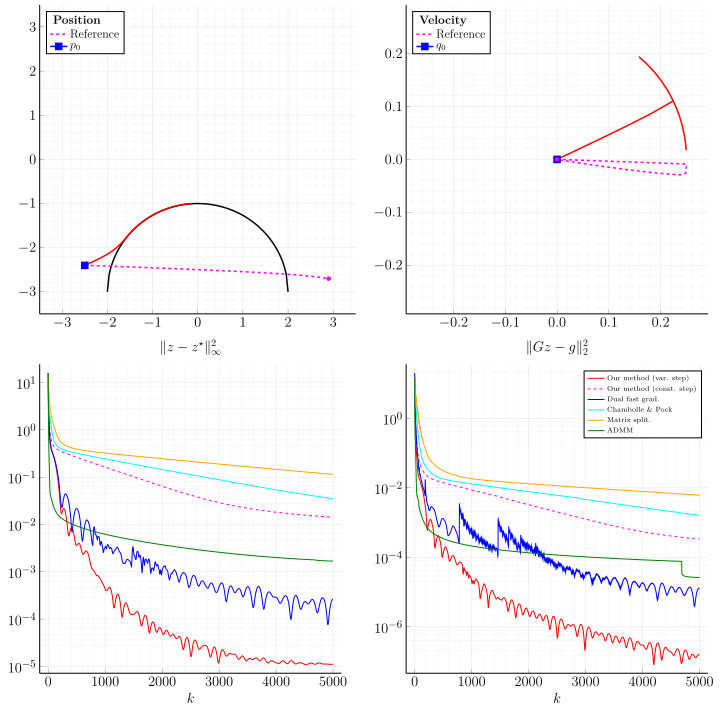

In [28]:
err_plot_func_coarse(Θ̌[1,1],Γ̌[1,1],xΨ)